In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
sns.set_palette("Set2")
palette = sns.color_palette("Set2")

import pycountry
import pycountry_convert as pc

import folium

from datetime import datetime

from src.utils.locationHelper import LocationHelper
from src.utils.preProcessingHelper import PreProcessRatings
import src.utils.preProcessingHelper as preProcessingHelper

from pandas.api.types import CategoricalDtype

import scipy.stats as stats
from scipy.stats import  kruskal, anderson, shapiro
import random

import src.utils.USClimateAndWeatherHelper as WaH
import plotly.express as px
import plotly.graph_objects as go

from src.utils.jeanneHelper import JeanneHelper, get_rating_per_month
helper = JeanneHelper()

import src.utils.seasonalityMetrics as sm # calls helper file

np.random.seed(42)

In [ ]:
# dataset we use
ph = PreProcessRatings("BeerAdvocate")
reviews_df = ph.get_dataframe(dataset="reviews", additinal_cols=["country_name", "country_code3", "state", "date_object", "month", "year", "style", "beer_name", "beer_id"])
reviews_df = reviews_df[(reviews_df["year"] >= 2002) & (reviews_df["country_code3"] == "USA")]
reviews_df.to_csv("src/data/beerAdvocateReviewsUSA.csv")

In [3]:
reviews_df = pd.read_csv("src/data/beerAdvocateReviewsUSA.csv", index_col=0)

In [4]:
reviews_df.head(10)

,rating,appearance,aroma,palate,taste,overall,country_name,country_code3,state,date_object,month,year,style,beer_name,beer_id
0,2.88,3.25,2.75,3.25,2.75,3.00,United States,USA,Washington,2015-08-20 12:00:00,8,2015,Euro Pale Lager,Régab,142544
1,3.67,3.00,3.50,3.50,4.00,3.50,United States,USA,New York,2009-02-20 12:00:00,2,2009,English Pale Ale,Barelegs Brew,19590
5,3.91,4.25,4.50,3.25,3.75,3.75,United States,USA,North Carolina,2013-02-13 12:00:00,2,2013,English Pale Ale,Legbiter,19827
6,3.64,4.00,3.75,3.50,3.50,3.75,United States,USA,New York,2013-01-09 12:00:00,1,2013,English Pale Ale,Legbiter,19827
7,2.77,3.00,3.50,2.50,2.50,2.50,United States,USA,Illinois,2012-11-17 12:00:00,11,2012,English Pale Ale,Legbiter,19827
8,3.68,4.00,3.50,4.00,3.50,4.00,United States,USA,Massachusetts,2012-07-14 12:00:00,7,2012,English Pale Ale,Legbiter,19827
9,2.84,4.50,3.00,3.50,2.50,2.50,United States,USA,North Carolina,2012-04-28 12:00:00,4,2012,English Pale Ale,Legbiter,19827
10,3.21,4.00,3.00,3.50,3.00,3.50,United States,USA,Illinois,2012-04-28 12:00:00,4,2012,English Pale Ale,Legbiter,19827
11,3.33,4.00,3.50,2.50,3.50,3.00,United States,USA,Virginia,2012-03-23 12:00:00,3,2012,English Pale Ale,Legbiter,19827
12,3.88,4.00,3.50,4.00,4.00,4.00,United States,USA,South Carolina,2011-12-10 12:00:00,12,2011,English Pale Ale,Legbiter,19827


In [11]:
fig = sm.monthly_avg_ci_fig(reviews_df, f'Avg rating per month with 95% confidence interval, n={reviews_df.shape[0]}')
fig.update_yaxes(range=[3.8, 3.9])
# fig.write_html("illustrations/Tim/generalAvgRatingLinePlot.html")
fig.show()


Variance over the means: 0.00014598136056148445


## grouped mean by beerType

In [ ]:
grouped_df = reviews_df.groupby(["month", "style"]).agg(rating = ("rating", "mean")).reset_index()
print(f'Kruskal statistics: {kruskal(*get_rating_per_month(grouped_df))}')

grouped_df = grouped_df.groupby("month")["rating"].agg(["mean", "count", "std"]).reset_index()


fig = sm.plot_with_ci(grouped_df, title=f'Grouped (over beer styles) mean rating with 95% confidence interval, n={reviews_df.shape[0]}')
fig.write_html("illustrations/Tim/groupedBeerStyleAvgRatingLinePlot.html")
fig.update_yaxes(range=[3.6, 3.9])


Kruskal statistics: KruskalResult(statistic=np.float64(1.5114800096752452), pvalue=np.float64(0.9996052219275736))
Variance over the means: 9.722658952948519e-05


If we group the beers by beer type and compute the mean rating over the groups per month, we can see that they take more or less the same mean for each month. Doing the kruskal test over these means, we can see that we can't reject the null hypothesis that the means differ from each other. Of course the confidence interval is much smaller as there are only about 100 different beer types.

## grouped by beer_id

In [7]:
grouped_df = reviews_df.groupby(["month", "beer_id"]).agg(rating = ("rating", "mean")).reset_index()
print(f'Kruskal statistics: {kruskal(*get_rating_per_month(grouped_df))}')

grouped_df = grouped_df.groupby("month")["rating"].agg(["mean", "count", "std"]).reset_index()


fig = sm.plot_with_ci(grouped_df, title=f'Grouped (over beer_id) mean rating with 95% confidence interval, n={reviews_df.shape[0]}')
# fig.write_html("illustrations/Tim/groupedBeerIdAvgRatingLinePlot.html")
fig.update_yaxes(range=[3.7, 3.8])

Kruskal statistics: KruskalResult(statistic=np.float64(170.83267759434938), pvalue=np.float64(7.95145751714161e-31))
Variance over the means: 8.541966555996275e-05


But if we group on the beer level and compute the grouped mean rating over the month, there is at least one month that significantly differs from the other months (p-value < 0.05). We want to further investigate which beers get have a seasonal impact?! For that, we take the frequency analysis to see if there are beers which have a seasonal impact on the rating. 

In [8]:
# convert date to datetime
reviews_df["date_object"].map(datetime.fromisoformat)

# we 16 years * 12 months = 192 months -> if a beer rating is uniformly distributed over the 196 months m. 
# The probability that for every beer and every month there is at least 1 review of that beer is >= 1 - m*e^{-n/m} (m is the nr of months, n the numbers of reviews for the beer)
# >= 1 - 192*exp(-1500/192) > 0.95 for n=1500 samples per beer...

CUTOFF = 500 # cutoff for beers to get into the stats

print("all shape: ", reviews_df.shape[0])

# trash all with less rating than CUTOFF
grouped_df = reviews_df.groupby("beer_id").agg(count = ("rating", "count")).reset_index()
grouped_df = grouped_df[grouped_df["count"] >= CUTOFF]
ids = grouped_df["beer_id"] # id's for beers with more than cutoff beers


print("reduced shape:", reviews_df[reviews_df["beer_id"].isin(ids)].shape[0])

reduced_df = reviews_df[reviews_df["beer_id"].isin(ids)]


grouped_df = reduced_df.groupby("beer_name")["rating"].agg("mean").reset_index()
grouped_df = grouped_df.set_index("beer_name")

for beerName in reduced_df["beer_name"].unique():

    timeseries_data  = sm.data_preprocessing_mean_rating_per_month(reduced_df[reduced_df["beer_name"] == beerName], 'mean_rating')
    timeseries_data, nrInterpolated = sm.interpolate_missing_vals_monthly(timeseries_data, col_to_interpolate="mean_rating")
    # print(f"interpolated: {nrInterpolated} values")
    # print(timeseries_data)
    peak_ratio, avg_amplitude = sm.timeseries_seasonality_metric(timeseries_data)
    # print(f'Beer Name: {beerName} \npeak Ratio: {peak_ratio}\navg Amplitude: {avg_amplitude}')
    # print()

    grouped_df.loc[beerName, "peak_ratio"] = peak_ratio
    grouped_df.loc[beerName, "avg_amplitude"] = avg_amplitude
    grouped_df.loc[beerName, "nr_interpolated"] = nrInterpolated


all shape:  2239823
reduced shape: 711007


<Axes: xlabel='peak_ratio', ylabel='avg_amplitude'>

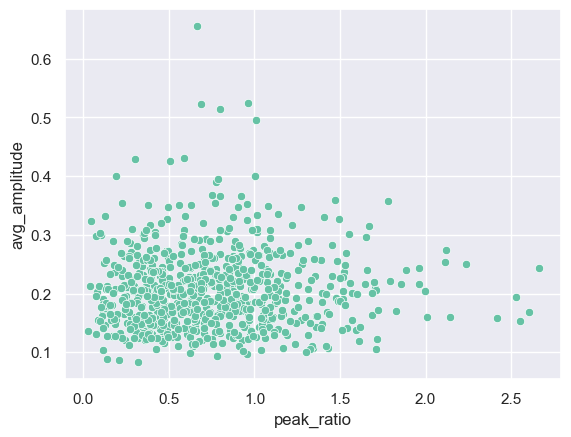

In [9]:
sns.scatterplot(grouped_df, x="peak_ratio", y="avg_amplitude")

In [19]:
grouped_df_peak_ratio = grouped_df.sort_values("peak_ratio", ascending=False)
grouped_df_peak_ratio.head()

,rating,peak_ratio,avg_amplitude,nr_interpolated
beer_name,,,,
Samuel Adams Alpine Spring,3.618500,2.6601,0.2431,42.0
Undercover Investigation Shut-down Ale,4.020939,2.6060,0.1684,22.0
Samuel Adams Holiday Porter,3.763881,2.5480,0.1535,50.0
Winter Storm Imperial ESB,3.856706,2.5267,0.1935,52.0
Fat Squirrel Ale,3.850240,2.4172,0.1584,34.0


In [20]:
# barplot for the beers with highest peak_ratio
df = grouped_df_peak_ratio.head(10)
fig = px.bar(df, y=df.index, x="peak_ratio", color=df.index, title="Beers with the highest Peak Ratio on the rating", labels={"beer_name": "Beer Name", "peak_ratio": "Peak Ratio"})

fig.update_layout(showlegend=False, height=700)
fig.write_html("illustrations/Tim/highestPeakRatioRating.html")
fig.show()

In [21]:
df = grouped_df_peak_ratio.tail(10)
fig = px.bar(df, y=df.index, x="peak_ratio", color=df.index, title="Beers with the lowest Peak Ratio on the rating", labels={"beer_name": "Beer Name", "peak_ratio": "Peak Ratio"})

fig.update_layout(showlegend=False, height=700)
fig.write_html("illustrations/Tim/lowestPeakRatioRating.html")
fig.show()

#### plot seasonal and residual parts for different thresholds

We fix different thresholds t. For each threshold t we classify the t*100% highest beers on the peak ratio as seasonal and the residual part as non-seasonal. For each t, we plot the seasonal and non-seasonal part against each other.

In [10]:
# add boolean for different thresholds
thresholds = [0.005, 0.01, 0.05, 0.1]
nr_thresholds = len(thresholds)

# copy the dataframe for each threshold
grouped_beer_thresh_df = grouped_df_peak_ratio.loc[np.repeat(grouped_df_peak_ratio.index, nr_thresholds)]
grouped_beer_thresh_df['thresh'] = np.tile(thresholds, len(grouped_df_peak_ratio))

# repeat dataframe for every threshold
for threshold in thresholds:
    nrTrues = int(len(grouped_df_peak_ratio) * threshold)
    nrFalse = len(grouped_df_peak_ratio) - nrTrues
    boolArr = np.concat((np.repeat(True, nrTrues), np.repeat(False, nrFalse)))
    grouped_beer_thresh_df.loc[grouped_beer_thresh_df["thresh"] == threshold, "is_seasonal"] = boolArr


# merge with the entire dataframe to get the ratings per month
grouped_beer_thresh_df = grouped_beer_thresh_df.drop(columns="rating") #drop rating as this is the mean rating which we don't need anymore
reviews_peak_thresh_df = pd.merge(grouped_beer_thresh_df, reviews_df, how="left", on="beer_name")

#group by month for the plot
grouped_peak_thresh_df = reviews_peak_thresh_df.groupby(["thresh", "is_seasonal", "month"])["rating"].agg("mean").reset_index()

grouped_peak_thresh_df.head()

NameError: name 'grouped_df_peak_ratio' is not defined

In [ ]:
for thresh in reviews_peak_thresh_df["thresh"].unique():
    df = reviews_peak_thresh_df[(reviews_peak_thresh_df["thresh"] == thresh) & (~reviews_peak_thresh_df["is_seasonal"])]
    print(f'Kruskal statistics: {kruskal(*get_rating_per_month(df))}')

In [23]:
fig = px.line(grouped_peak_thresh_df, x="month", y="rating", color="is_seasonal", facet_col="thresh", facet_col_wrap=1,
       facet_row_spacing=0.1,
       title="Avg rating per month for different thresholds on peak ratio metric"
       )
fig.for_each_annotation(lambda a: a.update(text=f'Threshold (ratio of beers classified as seasonal): {a.text.split("=")[-1]}'))
fig.write_html("illustrations/Tim/differentPeakRatioThresholds.html")
fig.show()

In [28]:
# show the variance for the residual 
df = grouped_peak_thresh_df[grouped_peak_thresh_df["is_seasonal"]]
df.loc[:, "thresh_str"] = df["thresh"].map(str)
fig = px.box(df, x="thresh_str", y="rating", color="thresh_str", labels={"thresh_str": "Threshold (% of beers classified as seasonal)", "rating": "Rating"},
             title="Grouped Mean (over monthly average Rating) of non-seasonal beers for different thresholds")
fig.update_layout(showlegend=False)

fig.write_html("illustrations/Tim/boxGroupedMonthlyMeanNonSeasonal.html")
fig.show()

/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_23204/1035173170.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
grouped_beer_stats_df = reviews_df.groupby(["beer_name", "month"])["rating"].agg(["mean"]).reset_index() # compute vals over months
grouped_beer_stats_df = grouped_beer_stats_df.groupby("beer_name").agg(var_over_months = ("mean", np.nanvar)).reset_index() # compute variance over mean of months for each beer
grouped_beer_stats_df = pd.merge(grouped_df_peak_ratio, grouped_beer_stats_df, on="beer_name")
fig = px.scatter(grouped_beer_stats_df, x="peak_ratio", y="var_over_months", labels={"peak_ratio": "Peak Ratio",
                  "var_over_months": "Variance over month mean"},
                  title="Variance over monthly mean rating and Peak Ratio Metric for each Beer"
                  )
fig.update_yaxes(range=[-0.01, 0.05])
fig.write_html("illustrations/Tim/peakRatio_vs_monthlyVariance.html")
fig.show()

/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_13266/1756631198.py:2: FutureWarning:

The provided callable <function nanvar at 0x10e9b23e0> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.



We can see that the variance over the monthly mean doesn't only come from the seasonality of the data but also from other factors as the variance and the Peak Ratio doesn't correlate.

In [24]:
seasonal_names = grouped_df_peak_ratio[grouped_df_peak_ratio["peak_ratio"] > 2].index
seasonal_beer_avgreviews_df = reviews_df[reviews_df["beer_name"].isin(seasonal_names)]
fig1 = sm.monthly_avg_ci_fig(seasonal_beer_avgreviews_df, f'Avg rating per month for seasonal beers with 95% confidence interval, n={seasonal_beer_avgreviews_df.shape[0]}')
fig1.show()

Variance over the means: 0.01574035333626742


In [25]:
non_seasonal_beer_avgreviews_df = reviews_df[~reviews_df["beer_name"].isin(seasonal_names)]
fig2 = sm.monthly_avg_ci_fig(non_seasonal_beer_avgreviews_df, f'Avg rating per month for NON seasonal beers with 95% confidence interval, n={non_seasonal_beer_avgreviews_df.shape[0]}')
fig2.show()

# TODO: combine these graphs

Variance over the means: 0.00014610795361064282


In [26]:
# fig = go.Figure(data = fig1.data + fig2.data)
def monthly_avg_ci_traces(df: pd.DataFrame, title: str):
    stats_df = df.groupby("month")["rating"].agg(["mean", "count", "std"]).reset_index()
    months = stats_df["month"].to_numpy()
    means = stats_df["mean"].to_numpy()
    ci_high = np.array([m + 1.96*s/np.sqrt(c) for _, m, c, s in stats_df.values])
    ci_low = np.array([m - 1.96*s/np.sqrt(c) for _, m, c, s in stats_df.values])

    # print(ci_high)
    print(f'Variance over the means: {np.var(means)}')
    line = go.Scatter(x=months, y=means,
                # title=title,
                name=title,
                mode="lines"
                )
    ci = go.Scatter(
            x=np.concat((months, months[::-1])), # x, then x reversed
            y=np.concat((ci_high, ci_low[::-1])), # upper, then lower reversed
            fill='toself',
            fillcolor='rgba(0,100,80,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False
        )
    return line, ci

line1, ci1 = monthly_avg_ci_traces(seasonal_beer_avgreviews_df, f'Avg rating per month for seasonal beers with 95% confidence interval, n={seasonal_beer_avgreviews_df.shape[0]}')
line2, ci2 = monthly_avg_ci_traces(non_seasonal_beer_avgreviews_df, f'Avg rating per month for NON seasonal beers with 95% confidence interval, n={non_seasonal_beer_avgreviews_df.shape[0]}')


fig = go.Figure(data=[line2, ci2, line1, ci1])

# Add layout for better appearance
fig.update_layout(
    title='Combined Plot with Different Colors',
    xaxis_title='X-axis',
    yaxis_title='Y-axis',
    legend=dict(title='Legend')
)

fig.show()

Variance over the means: 0.01574035333626742
Variance over the means: 0.00014610795361064282


We can see that we have a lot more variance for theses seasonal beers than for the others.

# histogram with total nr of reviews:

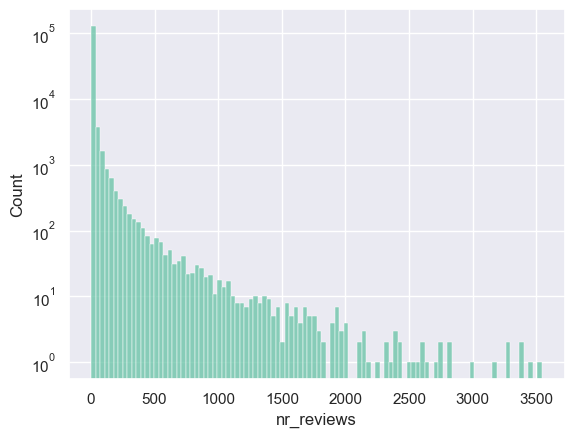

In [263]:
nr_agg = reviews_df.groupby("beer_id").agg(nr_reviews = ("rating", "count")).reset_index()
h = sns.histplot(nr_agg, x="nr_reviews", bins=100)
h.set_yscale('log')
# h.set_ybound(upper=200)

## Get most significant seasonal ratings beers

In [254]:
CUTOFF = 500 # cutoff for beers to get into the stats

print("all shape: ", reviews_df.shape[0])

# trash all with less than 12 ratings

nr_agg = reviews_df.groupby("beer_id").agg(count = ("rating", "count")).reset_index()
nr_agg = nr_agg[nr_agg["count"] >= CUTOFF]
ids = nr_agg["beer_id"]


print("reduced shape:", reviews_df[reviews_df["beer_id"].isin(ids)].shape[0])

reviews_df_more12 = reviews_df[reviews_df["beer_id"].isin(ids)]

sm.monthly_avg_ci_fig(reviews_df_more12, f'Avg rating per month with 95% confidence interval with at least {CUTOFF} reviews, n={reviews_df_more12.shape[0]}')


all shape:  2239823
reduced shape: 711007
Variance over the means: 0.00026220351599591686


In [258]:
# residual
residual_df = reviews_df[~reviews_df["beer_id"].isin(ids)]
sm.monthly_avg_ci_fig(residual_df, f'Avg rating per month with 95% confidence interval with at most {CUTOFF} reviews, n={residual_df.shape[0]}')


Variance over the means: 6.248338703890667e-05


In [249]:
monthly_reviews_df = reviews_df_more12.groupby(["beer_id", "month"]).agg(mean_rating = ("rating", "mean")).reset_index()
monthly_reviews_df = monthly_reviews_df.pivot(index="beer_id", columns="month", values="mean_rating")
# monthly_reviews_df.head(10)
print(f'shape without removing rows containing nans: {monthly_reviews_df.shape[0]}')

# remove na rows
monthly_reviews_df = monthly_reviews_df[monthly_reviews_df.notna().all(axis=1)]
print(f'shape after removing rows containing nans: {monthly_reviews_df.shape[0]}')

shape without removing rows containing nans: 239
shape after removing rows containing nans: 239


In [226]:
monthly_reviews_df["var"] = np.nanvar(monthly_reviews_df.to_numpy(), axis=1) #var ignoring nans

In [ ]:
# beer_id's sorted in ascending variance
seasonal_beer_ids = monthly_reviews_df.sort_values("var", ascending=False).head(int(0.1 * len(monthly_reviews_df))).index

In [238]:
variance_reviews_df = reviews_df[reviews_df["beer_id"].isin(seasonal_beer_ids)]
sm.monthly_avg_ci_fig(variance_reviews_df,
                   title = f'Avg rating per month for high variance beers with 95% confidence interval, n={variance_reviews_df.shape[0]}')

Variance over the means: 0.0049782992066148704


In [239]:
kruskal(*get_rating_per_month(variance_reviews_df))


KruskalResult(statistic=np.float64(313.64682057873375), pvalue=np.float64(1.1628177900460184e-60))

In [240]:
lowvariance_reviews_df = reviews_df_more12[~reviews_df_more12["beer_id"].isin(seasonal_beer_ids)]
sm.monthly_avg_ci_fig(lowvariance_reviews_df,
                   title=f'Avg rating per month for residual beers with 95% confidence interval, n={lowvariance_reviews_df.shape[0]}')

Variance over the means: 0.00013126486730887798


In [233]:
kruskal(*get_rating_per_month(lowvariance_reviews_df))

KruskalResult(statistic=np.float64(184.79896082599265), pvalue=np.float64(1.045942533860179e-33))

In [253]:
# identify beer with highest variance
most_var_beer_df = reviews_df[reviews_df["beer_id"] == seasonal_beer_ids[3]]
sm.monthly_avg_ci_fig(most_var_beer_df,
                   title = f'Avg rating per month for beer with highest variance with 95% confidence interval, n={most_var_beer_df.shape[0]}')

Variance over the means: 0.025798978063685366
